In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.cm as cm
from scipy import stats
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull, convex_hull_plot_2d

### plot parameters
pp = pd.read_csv('plotparams.csv',index_col=0)

# Notebook 3: solute data analysis and rain water fractions (F$_{\mathrm{rw}}$)

This notebook performs calculations on solute data for streamflow and precipitation in the Luquillo Mountains. We use principal components analysis (PCA) to perform endmember mixing analysis (EMMA) to evaluate streamflow as a mixture of multiple source waters. We find that only two endmembers are necessary, groundwater and rainwater, and we compute the fraction of streamflow derived from rainwater (F$_{\mathrm{rw}}$).

In [19]:
## read in CQ
cq = pd.read_csv('data/WRR2025_cq.csv',parse_dates=['datetime'],low_memory=False)

### read in endmembers
## Bisley rain
infile3  ="https://pasta.lternet.edu/package/data/eml/knb-lter-luq/174/2110859/da51d75107589e890aeaf5a4c36f0f4c".strip() 
infile3  = infile3.replace("https://","http://")               
bisleyrain =pd.read_csv(infile3,parse_dates=['Sample_Date'])

## El Verde rain
infile4  ="https://pasta.lternet.edu/package/data/eml/knb-lter-luq/174/2110859/28d1ddb6464df58ffec5db4612aca2b6".strip() 
infile4  = infile4.replace("https://","http://")              
evrain =pd.read_csv(infile4,parse_dates=['Sample_Date'])

## Bisley throughfall
infile6  ="https://pasta.lternet.edu/package/data/eml/knb-lter-luq/174/2110859/09ff0efc017f7b271a5c8c2ec367cc93".strip() 
infile6  = infile6.replace("https://","http://")           
bisleytfall =pd.read_csv(infile6,parse_dates=['Sample_Date'])

## El Verde porewater
infile1  ="https://pasta.lternet.edu/package/data/eml/knb-lter-luq/166/731255/f38ebdcf7852a667f52fd5fd7d041650".strip() 
infile1  = infile1.replace("https://","http://")
evpw =pd.read_csv(infile1,sep=",",parse_dates=['Date'])
evpw = evpw[evpw['Treatment']=='Control'] # use only control data, not from experimental disturbance sites

## Bisley porewater from Buss et al., 2017
bisleypw = pd.read_csv('downloaded/Buss2017.csv',encoding='latin-1')
for c in bisleypw.columns[3:]: # separate +/- stdev
    bisleypw.loc[:,c+'stdev'] = [float(i.split('±')[1]) for i in bisleypw.loc[:,c]] 
    bisleypw.loc[:,c] = [float(i.split('±')[0]) for i in bisleypw.loc[:,c]] 
# separate shallow and deep
bisleypw_s = bisleypw[bisleypw['depth']<0.5] # shallow
bisleypw_d = bisleypw[bisleypw['depth']>0.5] # deep

## Icacos porewater from Kurtz et al., 2011
icacospw = pd.read_excel('downloaded/Kurtz2011.xlsx',na_values=['ND'])
icacospw_s = icacospw[icacospw['Depth (cm)']<50]
icacospw_d = icacospw[icacospw['Depth (cm)']>50]
# add data from White et al., 1998
whitepw = pd.read_csv('downloaded/white1998.csv',na_values=['nd'])
whitepw = whitepw[whitepw['depth']>0.5]  ## all data from White et al., 1998 is >0.5m except for river/rain/throughfall

icacospw_d = pd.concat([icacospw_d,whitepw],axis=0) # add to deep porewater

## Groundwater data from Hynek et al., 2022
gw = pd.read_csv('downloaded/Hynek_2022.csv')
icacosgw = gw[gw['Site ID'].isin(['Guaba bog','Guaba slide','R191seep','LGW1','LGW2B','LGW2C','EP1'])] # wells over granitoid
bisleygw = gw[gw['Site ID'].isin(['EP1','Palo Colorado','Caimitillo','Aviary'])] # wells over volcaniclastic / hornfels (EP1 is on the border)

In [20]:
### define elements, remove rows with any nans, convert units
elementlist = ['Na','Ca','Mg','Cl']
molws = [22.9898,24.312,40.08,35.45]   
# molws = np.ones(len(dictelements))
moldict = dict(zip(elementlist,molws))

# remove nans
evrain = evrain[~pd.isnull(evrain.loc[:,elementlist]).any(axis=1)].reset_index()
bisleyrain = bisleyrain[~pd.isnull(bisleyrain.loc[:,elementlist]).any(axis=1)].reset_index()
bisleytfall = bisleytfall[~pd.isnull(bisleytfall.loc[:,elementlist]).any(axis=1)].reset_index()
evpw = evpw[~pd.isnull(evpw.loc[:,elementlist]).any(axis=1)].reset_index()
bisleypw_s = bisleypw_s[~pd.isnull(bisleypw_s.loc[:,elementlist]).any(axis=1)].reset_index()
bisleypw_d = bisleypw_d[~pd.isnull(bisleypw_d.loc[:,elementlist]).any(axis=1)].reset_index()
icacospw_s = icacospw_s[~pd.isnull(icacospw_s.loc[:,elementlist]).any(axis=1)].reset_index()
icacospw_d = icacospw_d[~pd.isnull(icacospw_d.loc[:,elementlist]).any(axis=1)].reset_index()
gw = gw[~pd.isnull(gw.loc[:,elementlist]).any(axis=1)].reset_index()
icacosgw = icacosgw[~pd.isnull(icacosgw.loc[:,elementlist]).any(axis=1)].reset_index()
bisleygw = bisleygw[~pd.isnull(bisleygw.loc[:,elementlist]).any(axis=1)].reset_index()

# convert units to mg/L, for consistency with the compiled cq dataset (I prefer mM, but it's easier to match the existing dataset)
for e in elementlist:
    # uM to mM to mg/L
    bisleypw_s.loc[:,e] = bisleypw_s.loc[:,e]*moldict[e]/1000 
    bisleypw_d.loc[:,e] = bisleypw_d.loc[:,e]*moldict[e]/1000 
    icacospw_s.loc[:,e] = icacospw_s.loc[:,e]*moldict[e]/1000
    icacospw_d.loc[:,e] = icacospw_d.loc[:,e]*moldict[e]/1000
    icacosgw.loc[:,e] = icacosgw.loc[:,e]*moldict[e]/1000
    bisleygw.loc[:,e] = bisleygw.loc[:,e]*moldict[e]/1000
    gw.loc[:,e] = gw.loc[:,e]*moldict[e]/1000

In [21]:
###  some print statements
print('Length of datasets:')
datasetlist = ['EV rain','BIS rain','BIS tfall','EV PW','BIS PW S','BIS PW D','ICA PW S','ICA PW D','BIS GW','ICA GW','Hynek GW']
for i,em in enumerate([evrain,bisleyrain,bisleytfall,evpw,bisleypw_s,bisleypw_d,icacospw_s,icacospw_d,bisleygw,icacosgw,gw]):
    
    print(f'{datasetlist[i]}: {len(em)}')
    
print('Date ranges of rainfall datasets:')
for i,em in enumerate([evrain,bisleyrain,bisleytfall]):
    print(f'{datasetlist[i]}: {np.min(em["Sample_Date"])} - {np.max(em["Sample_Date"])}')    

Length of datasets:
EV rain: 1348
BIS rain: 1193
BIS tfall: 1357
EV PW: 1309
BIS PW S: 10
BIS PW D: 28
ICA PW S: 8
ICA PW D: 9
BIS GW: 23
ICA GW: 91
Hynek GW: 106
Date ranges of rainfall datasets:
EV rain: 1983-11-28 00:00:00 - 2018-12-25 00:00:00
BIS rain: 1988-03-23 00:00:00 - 2018-12-25 00:00:00
BIS tfall: 1986-07-01 00:00:00 - 2018-12-25 00:00:00


RI: 2461 rows of data
RI: 1127 rows with all elements
27 samples had at least one solute outside mean+/3sd
QG: 1757 rows of data
QG: 1021 rows with all elements
20 samples had at least one solute outside mean+/3sd
MPR: 3017 rows of data
MPR: 1520 rows with all elements
39 samples had at least one solute outside mean+/3sd
Q3: 1633 rows of data
Q3: 1391 rows with all elements
51 samples had at least one solute outside mean+/3sd
QS: 1927 rows of data
QS: 1652 rows with all elements
63 samples had at least one solute outside mean+/3sd
QP: 1071 rows of data
QP: 1021 rows with all elements
32 samples had at least one solute outside mean+/3sd


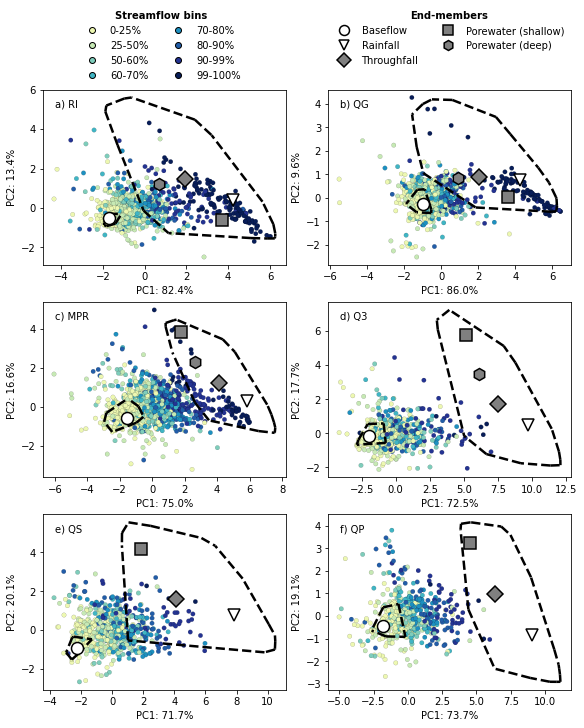

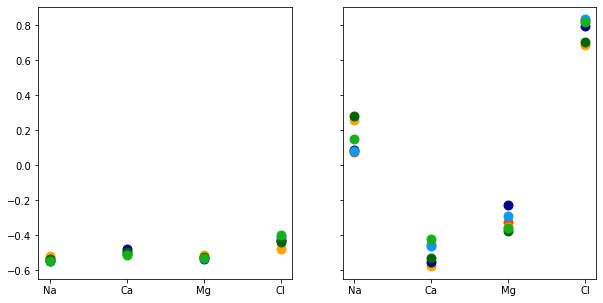

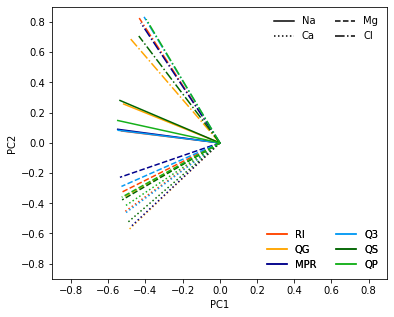

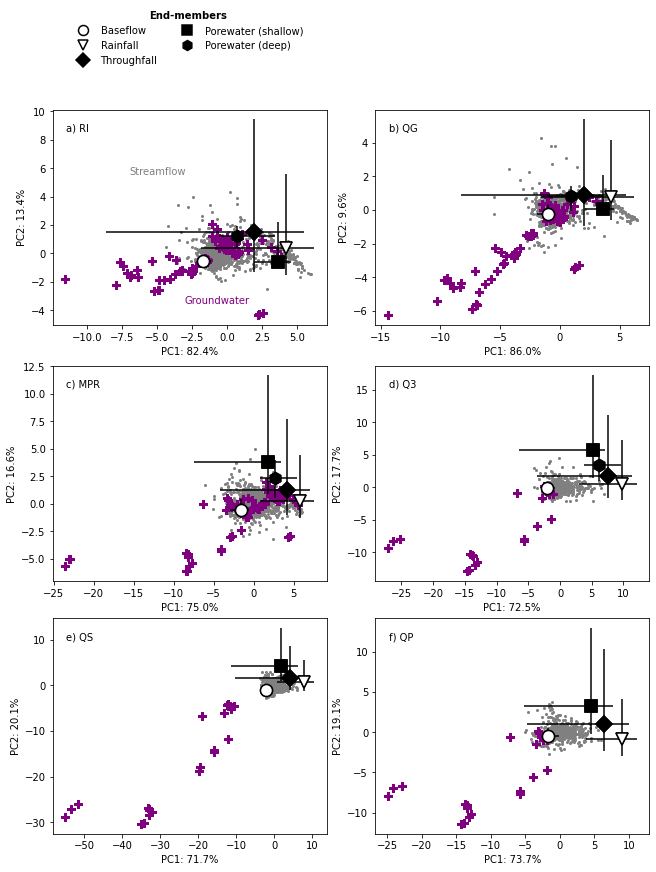

In [25]:
### PREP FOR PCA
sitelist = ['RI','QG','MPR','Q3','QS','QP']
backwardslist = ['MPR'] # after PCA, need to flip MPR data on the x axis so it plots nicely with other sites
upsidedownlist = [''] # same but flip QS data on y axis

### OPTIONS
# number of iterations: we use 10,000 for the manuscript, which takes a long time. Consider using 100 to explore
iternum = 10000 #iternum = 100
# option to save data 
savedata=True
# number of endmembers
numendmembers = 2
# sd: set standard deviation around which to exclude outliers
mysd = 3

pcdf = pd.DataFrame() # dataframe to save principal components

# endmember colors and shapes
EMcolors = ['yellow','xkcd:azure','orange','magenta','brown','purple']
EMshapes = ['v','D','o','s','h','P']

### initialize plots
fig,ax = plt.subplots(3,2,figsize=(8,10),constrained_layout=True)#,tight_layout=True)
ax = ax.flatten()

fig2,ax2 = plt.subplots(1,2,figsize=(10,5),sharey=True)
ax2 = ax2.flatten()
fig2b,ax2b = plt.subplots(1,1,figsize=(6,5))

fig3,ax3 = plt.subplots(3,2,figsize=(9,12),constrained_layout=True)
ax3 = ax3.flatten()

### begin PCA on each site
for i,site in enumerate(sitelist):
    
    tempdf = cq.loc[cq['site']==site]
    print(f'{site}: {tempdf.shape[0]} rows of data')
    tempdf = tempdf.dropna(subset=elementlist)
    length1 = tempdf.shape[0]
    print(f'{site}: {length1} rows with all elements')
    
    # screen for outliers outside 3SD
    outliers = ~(np.abs(stats.zscore(tempdf[elementlist])) < mysd).all(axis=1) # find outliers not inside sd
    print(f'{len(tempdf[outliers])} samples had at least one solute outside mean+/{mysd}sd')
    tempdf = tempdf[~outliers]
    
    # remove points with no discharge data
    tempdf = tempdf[~np.isnan(tempdf['discharge(m/yr)'])] 
    
    # load only solute data
    X = np.array(tempdf.loc[:,elementlist])
    # scale it
    stream_means = X.mean(0)
    stream_stds = X.std(0)
    x_scaled = (X-stream_means)/stream_stds # standardized by centering to mean and scaling to std
    
    # do PCA
    pca = PCA()
    x_new = pca.fit_transform(x_scaled)
    score = x_new[:,0:numendmembers] # get scores (eigenvalues) for the first few PCs 
    coeff = np.transpose(pca.components_[0:numendmembers, :])# get eigenvectors for first few PCs
    pc1 = score[:,0]
    pc2 = score[:,1]
    n = coeff.shape[0]

    # flipping things so they all align on a plot
    if site in backwardslist:
        pc1*=-1
    if site in upsidedownlist:
        pc2*=-1
    
    tempdf['pc1'] = pc1
    tempdf['pc2'] = pc2
    
    ## plot component scores
    pc1score = pca.components_[0,:]
    pc2score = pca.components_[1,:]
    
    if (site in backwardslist):
        pc1score *= -1
    if (site in upsidedownlist):
        pc2score *=-1
    
    ax2[0].scatter(elementlist,list(pc1score),c=pp.color[site],s=80)
    ax2[1].scatter(elementlist,list(pc2score),c=pp.color[site],label='_nolegend_',s=80)
    
    ### Supplemental plot 7 shows variable loadings
    mylines = []
    mylinelines = ['solid','dotted','dashed','dashdot']
    for line in range(0,4):
        ax2b.plot([0,pc1score[line]],[0,pc2score[line]],c=pp.color[site],ls=mylinelines[line])
            
    legend_e= [Line2D([0], [0],ls=mylinelines[0], c='k', label=elementlist[0]),
                Line2D([0], [0],ls=mylinelines[1], c='k', label=elementlist[1]),
                Line2D([0], [0],ls=mylinelines[2], c='k', label=elementlist[2]),
                Line2D([0], [0],ls=mylinelines[3], c='k',label=elementlist[3])]

    ax2b_l1 = ax2b.legend(handles=legend_e,ncol=2,loc='upper right',frameon=False)
    
    legend_s= [Line2D([0], [0],ls='-', c=pp.color[s], label=s) for s in sitelist]
    ax2b_l2 = ax2b.legend(handles=legend_s,ncol=2,loc='lower right',frameon=False)
    
    if site ==sitelist[-1]:
        ax2b.add_artist(ax2b_l1)
        ax2b.add_artist(ax2b_l2)
        
        ax2b.set_xlim([-0.9,0.9])
        ax2b.set_ylim([-0.9,0.9])
        
        ax2b.set_xlabel('PC1')
        ax2b.set_ylabel('PC2')
    
    
    ### add points for Supplemental plot 6, no discharge color coding
    ax3[i].plot(pc1,pc2,ls='',markersize=2,marker='o',c='gray',zorder=0)
    
    # Main text plot 6: streamflow color coded by discharge
    dischargelist = [0,25,50,60,70,80,90,99]
    dischargetops = [25,50,60,70,80,90,99,100]
    
    cmap = cm.get_cmap('YlGnBu')
    colors = cmap(np.linspace(1/len(dischargelist),1,len(dischargelist)))
      
    for ib,val in enumerate(dischargelist):
          
        tempdf.loc[(tempdf['rank']>=val) &(tempdf['rank']<dischargetops[ib]),'binnum'] = int(ib)

    binnum_int = [int(i) if ~np.isnan(i) else np.nan for i in tempdf['binnum']]
    
    ax[i].scatter(tempdf['pc1'],tempdf['pc2'],marker='o',label='_nolegend_',facecolor=colors[binnum_int],s=20,edgecolor='k',lw=0.1)

    ## chemically distinct baseflow ( not used for manuscript)  
    bf_1 =tempdf[tempdf['pc1']>=np.percentile(tempdf['pc1'],95)]
    bf_2 =tempdf[tempdf['pc1']>=np.percentile(tempdf['pc1'],95)]

    bf_1 =tempdf[tempdf['pc1']<=np.percentile(tempdf['pc1'],5)]
    bf_2 =tempdf[tempdf['pc1']<=np.percentile(tempdf['pc1'],5)]
    
    ### choose endmembers. this could probably be neater
    if ((site == 'RI') | (site=='QG')):
        raindf = bisleyrain
        tfalldf = bisleytfall
        bfdf = tempdf[tempdf['discharge(m/yr)']<=np.nanpercentile(tempdf['discharge(m/yr)'],2)].reset_index() # lowest 2%
        pwsdf = icacospw_s
        pwddf = icacospw_d
        gwdf = icacosgw
                
        emnames = ['RF','TF','BF','PWs','PWd','GW']
        emdflist = [raindf,tfalldf,bfdf,pwsdf,pwddf,gwdf]

        if numendmembers==2:
            usedindex = [0,2]
        else:
            usedindex = [0,1,2]

    elif ((site == 'MPR') | (site=='Q3')):
        raindf = bisleyrain
        tfalldf = bisleytfall
        bfdf = tempdf[tempdf['discharge(m/yr)']<=np.nanpercentile(tempdf['discharge(m/yr)'],2)].reset_index() # lowest 2%
        pwsdf = bisleypw_s
        pwddf = bisleypw_d
        
        if site=='MPR':
            gwdf = gw # MPR spans a number of lithologies, use Hynek 2022 dataset
        else:
            gwdf = bisleygw # Q3 just gets bisley groundwater
        
        emnames = ['RF','TF','BF','PWs','PWd','GW']
        emdflist = [raindf,tfalldf,bfdf,pwsdf,pwddf,gwdf]

        if numendmembers==2:
            usedindex = [0,2]
        else:
            usedindex = [0,1,2]

    else: # QS and QP
        raindf = evrain
        tfalldf = bisleytfall
        bfdf = tempdf[tempdf['discharge(m/yr)']<=np.nanpercentile(tempdf['discharge(m/yr)'],2)].reset_index() # lowest 2%
        pwsdf = evpw
        gwdf = bisleygw
        
        emnames = ['RF','TF','BF','PWs','GW']
        emdflist = [raindf,tfalldf,bfdf,pwsdf,gwdf]

        if numendmembers==2:
            usedindex = [0,2]
        else:
            usedindex = [0,1,2]
    
    shapes = ['v','d','s','H','H','P'] # these are for plotting different endmembers
    
    # initialize
    endmembers = np.zeros([iternum,len(emdflist),len(elementlist)])
    endmembers_scores = np.zeros([iternum,len(emdflist),numendmembers])
    endmembers_transformed = np.zeros([iternum,len(emdflist),2])
    endmembers_fractions = np.zeros([iternum,len(score),numendmembers])

    ## iterate 1000 times and sample endmembers from distribution
    for j in range(0,iternum):
        for emnum,emdf in enumerate(emdflist):                
            # sample endmember dfs
            endmembers[j,emnum,:] = np.array(emdf.loc[np.random.randint(0,np.max(emdf.index)+1),elementlist])
            
            ## iterate through the 1000 endmember combinations and compute fractional contribution (yields 1000 fractions per sample)          
            temp = endmembers[j,emnum,:]

            # project into pc space 
            temp = (temp.reshape(1,-1)-stream_means)/stream_stds
            transform = pca.transform(temp)
            scoret = transform[:,0:(numendmembers)] # pc scores (keep 2 just for plotting purposes)
    
            pc1_em = scoret[:,0]
            pc2_em = scoret[:,1]
            
            # scores which we will be computing mixing fractions with
            # added an extra column at the beginning because mixing analyses assumes fraction sums to 1
            endmembers_scores[j,emnum,0] =1 # this is the closure constraint
            endmembers_scores[j,emnum,1:(numendmembers)] = scoret[:,0:(numendmembers-1)] # these are the endmembers

            # this is for plotting
            endmembers_transformed[j,emnum,0] = pc1_em
            endmembers_transformed[j,emnum,1] = pc2_em
            
        # add fractions using scores
        endmembers_fractions[j,:,:] = np.array([np.linalg.solve(endmembers_scores[j,usedindex,:].T,np.vstack(np.append(np.array([1]),s[0:(numendmembers-1)]))) for s in score])[:,:,0]
        
    # intialize mixing fraction summaries 
    fraction_medians = np.zeros([len(score),numendmembers])
    fraction_stdevs = np.zeros([len(score),numendmembers])
    fraction_lower5 = np.zeros([len(score),numendmembers])
    fraction_upper5 = np.zeros([len(score),numendmembers])
    fraction_lower25 = np.zeros([len(score),numendmembers])
    fraction_upper25 = np.zeros([len(score),numendmembers])

    ### initialize "back-calculated" dataframe
    backcalculated = np.zeros([iternum,len(score),len(elementlist)])
    
    for s in range(0,len(score)):
        # backcalculated
        backcalculated[:,s,:] = np.vstack(endmembers_fractions[:,s,0])*endmembers[:,usedindex[0],:]+np.vstack(endmembers_fractions[:,s,1])*endmembers[:,usedindex[1],:]
        
        fraction_medians[s,:] = [np.nanmedian(endmembers_fractions[:,s,i]) for i in range(0,numendmembers)]
        fraction_stdevs[s,:] = [np.nanstd(endmembers_fractions[:,s,i]) for i in range(0,numendmembers)]
        fraction_lower5[s,:] = [np.nanpercentile(endmembers_fractions[:,s,i],5) for i in range(0,numendmembers)]
        fraction_upper5[s,:] = [np.nanpercentile(endmembers_fractions[:,s,i],95) for i in range(0,numendmembers)]
        fraction_lower25[s,:] = [np.nanpercentile(endmembers_fractions[:,s,i],25) for i in range(0,numendmembers)]
        fraction_upper25[s,:] = [np.nanpercentile(endmembers_fractions[:,s,i],75) for i in range(0,numendmembers)]

    ### draw endmembers
    for emi in range(0,len(emdflist)):    
        x = endmembers_transformed[:,emi,0]
        y= endmembers_transformed[:,emi,1]
        
        # query 5-95% 
        outerquery = (x>np.percentile(x,5)) & (x<np.percentile(x,95)) & (y>np.percentile(y,5)) & (y<np.percentile(y,95))
        
        x_outer = x[outerquery]
        y_outer = y[outerquery]
        
        # pairs for convex hull
        paired_outer = np.array([[x,y] for x,y in zip(x_outer,y_outer)])

        # try to make a convex hull: if it fails, there's not enough data
        badem = False
        try:
            hull_outer = ConvexHull(paired_outer)
        except:
            print('not enough data for outer hull for this endmember')
            badem=True
            
        if ((emi in usedindex)): # this plots the used endmembers baseflow and rainfall
            
            ax[i].plot(np.median(x),np.median(y),ls='',markeredgecolor='k',markerfacecolor='white',zorder=5,markersize=12,marker=EMshapes[emi],markeredgewidth=1.5)

            ax3[i].plot(np.median(x),np.median(y),ls='',c='k',markerfacecolor='w',zorder=5,markersize=12,marker=EMshapes[emi],markeredgewidth=1.5)
            ax3[i].errorbar(np.median(x),np.median(y),xerr=[[np.median(x)-np.min(x_outer)],[np.max(x_outer)-np.median(x)]],
                                yerr=[[np.median(y)-np.min(y_outer)],[np.max(y_outer)-np.median(y)]],ls='',c='k',markerfacecolor='w',zorder=3,markersize=12,marker=EMshapes[emi],markeredgewidth=1.5)
          
            # plot the convex hull only for used endmembers
            for si,simplex in enumerate(hull_outer.simplices):
                if si==0:
                    label = '5-95%'
                else:
                    label='_nolegend_'
                ax[i].plot(paired_outer[simplex, 0], paired_outer[simplex, 1], color='k',ls='--',lw=2.5,label=label)
       
        else: # plot other endmembers
            if emnames[emi]=='GW': # groundwater is excluded from Fig 6 in the main text, include in supplemental plot 6
                ax3[i].plot(x,y,ls='',markersize=8,marker=EMshapes[5],c='purple',zorder=1)
            elif not badem:
                ax3[i].plot(np.median(x),np.median(y),ls='',markeredgecolor='black',markerfacecolor='k',zorder=4,markersize=12,marker=EMshapes[emi],markeredgewidth=1.5)
                ax3[i].errorbar(np.median(x),np.median(y),xerr=[[np.median(x)-np.min(x_outer)],[np.max(x_outer)-np.median(x)]],
                      yerr=[[np.median(y)-np.min(y_outer)],[np.max(y_outer)-np.median(y)]],ls='',c='k',zorder=2,markersize=12,marker=EMshapes[emi],markeredgewidth=1.5)
                  
             
                ax[i].plot(np.median(x),np.median(y),ls='',markeredgecolor='k',markerfacecolor='gray',zorder=4,markersize=12,marker=EMshapes[emi],markeredgewidth=1.5)

            else:
                print(f'didnt plot {emnames[emi]} for {site}')

    
    if savedata: 
        outputdf = tempdf
        # medians
        outputdf['F1_med'] = fraction_medians[:,0]
        outputdf['F2_med'] = fraction_medians[:,1]
        
        for ei, e in enumerate(elementlist):
            # backcalculated solute data
            # 5-95 percentile, median, mean
            outputdf[f'{e}_backcalc_5'] = np.nanpercentile(backcalculated[:,:,ei],5,axis=0)
            outputdf[f'{e}_backcalc_95'] = np.nanpercentile(backcalculated[:,:,ei],95,axis=0)
            outputdf[f'{e}_backcalc_med'] = np.nanmedian(backcalculated[:,:,ei],axis=0)
            outputdf[f'{e}_backcalc_mean'] = np.nanmean(backcalculated[:,:,ei],axis=0)

        # fraction standard deviation, 5-95%, 25-75%
        outputdf['F1_std'] = fraction_stdevs[:,0]
        outputdf['F2_std'] = fraction_stdevs[:,1]  
        outputdf['F1_5'] = fraction_lower5[:,0]
        outputdf['F2_5'] = fraction_lower5[:,1]
        outputdf['F1_95'] = fraction_upper5[:,0]
        outputdf['F2_95'] = fraction_upper5[:,1]
        outputdf['F1_25'] = fraction_lower25[:,0]
        outputdf['F2_25'] = fraction_lower25[:,1]
        outputdf['F1_75'] = fraction_upper25[:,0]
        outputdf['F2_75'] = fraction_upper25[:,1]
        
        # export summary results
        outputdf.to_csv(f'EMMAresults/{site}_{"-".join(elementlist)}.csv')
        
        # intialize "long results" with all 10,000 Monte Carlo iterations....
        longoutputdf = outputdf.reset_index().join(pd.DataFrame(endmembers_fractions[:,:,0].T,columns=[str(i) for i in range(0,iternum)]))
        longoutputdf.to_csv(f'EMMAresults/{site}_{"-".join(elementlist)}_long.csv')

    ## plot labels 
    ax[i].set_xlabel(f"PC1: {pca.explained_variance_ratio_[0]*100:.1f}%")
    ax[i].set_ylabel(f"PC2: {pca.explained_variance_ratio_[1]*100:.1f}%")
    ax3[i].set_xlabel(f"PC1: {pca.explained_variance_ratio_[0]*100:.1f}%")
    ax3[i].set_ylabel(f"PC2: {pca.explained_variance_ratio_[1]*100:.1f}%")
    
    # make legends manually:
    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D   

    # discharge bin labels Figure 6
    dischargelabels = [f'{i}-{j}%' for i,j in zip(dischargelist,dischargetops)]
    legend_bins= [Line2D([0], [0],ls='', marker='o',color=colors[i],markersize=6,markeredgecolor='k',lw=0.1,label=dischargelabels[i]) for i in range(0,len(dischargelist))]

    # endmember labels Figure 6
    legend_em= [Line2D([0], [0],ls='', marker='o',color='k',markerfacecolor='w',markersize=10,markeredgewidth=1.5,label='Baseflow'),
                       Line2D([0], [0],ls='', marker='v',color='k',markerfacecolor='w',markersize=10,markeredgewidth=1.5,label='Rainfall'),
                       Line2D([0], [0],ls='', marker='D',color='k',markerfacecolor='gray',markersize=10,markeredgewidth=1.5,label='Throughfall'),
                       Line2D([0], [0],ls='', marker='s',color='k',markerfacecolor='gray',markersize=10,markeredgewidth=1.5,label='Porewater (shallow)'),
                       Line2D([0], [0],ls='', marker='h',color='k',markerfacecolor='gray',markersize=10,markeredgewidth=1.5,label='Porewater (deep)')]
    # endmember labels for Supplemental plot 6
    legend_em2= [Line2D([0], [0],ls='', marker='o',color='k',markerfacecolor='w',markersize=10,markeredgewidth=1.5,label='Baseflow'),
                       Line2D([0], [0],ls='', marker='v',color='k',markerfacecolor='w',markersize=10,markeredgewidth=1.5,label='Rainfall'),
                       Line2D([0], [0],ls='', marker='D',color='black',markerfacecolor='k',markersize=10,markeredgewidth=1.5,label='Throughfall'),
                       Line2D([0], [0],ls='', marker='s',color='black',markerfacecolor='k',markersize=10,markeredgewidth=1.5,label='Porewater (shallow)'),
                       Line2D([0], [0],ls='', marker='h',color='black',markerfacecolor='k',markersize=10,markeredgewidth=1.5,label='Porewater (deep)')]
    
    # add legends
    legend1 = ax[0].legend(handles=legend_bins,bbox_to_anchor=[0.85,1.5],frameon=False,ncol=2,title='Streamflow bins', title_fontproperties={'weight':'bold'})
    legend2 = ax[1].legend(handles=legend_em,bbox_to_anchor=[1.01,1.5],frameon=False,ncol=2,title='End-members', title_fontproperties={'weight':'bold'})
    legend3 = ax3[0].legend(handles=legend_em2,bbox_to_anchor=[0.95,1.5],frameon=False,ncol=2, title='End-members',title_fontproperties={'weight':'bold'})

# some more labels    

# sites
letterlabels = ['a) RI','b) QG','c) MPR','d) Q3','e) QS','f) QP']
[ax[i].text(0.05,0.9,letterlabels[i],transform=ax[i].transAxes) for i in range(0,6) ]
[ax3[i].text(0.05,0.9,letterlabels[i],transform=ax3[i].transAxes) for i in range(0,6) ]

# stream and groundwater in Supp plot 6
ax3[0].text(0.48,0.1,'Groundwater',transform=ax3[0].transAxes,c='purple')
ax3[0].text(0.28,0.7,'Streamflow',transform=ax3[0].transAxes,c='gray')


## save figures
fig2b.savefig('plots/FigS7_PCAvectors.pdf')
fig.savefig('plots/Fig6_PCA.pdf') 
fig3.savefig('plots/FigS8_PCAgw.pdf') 

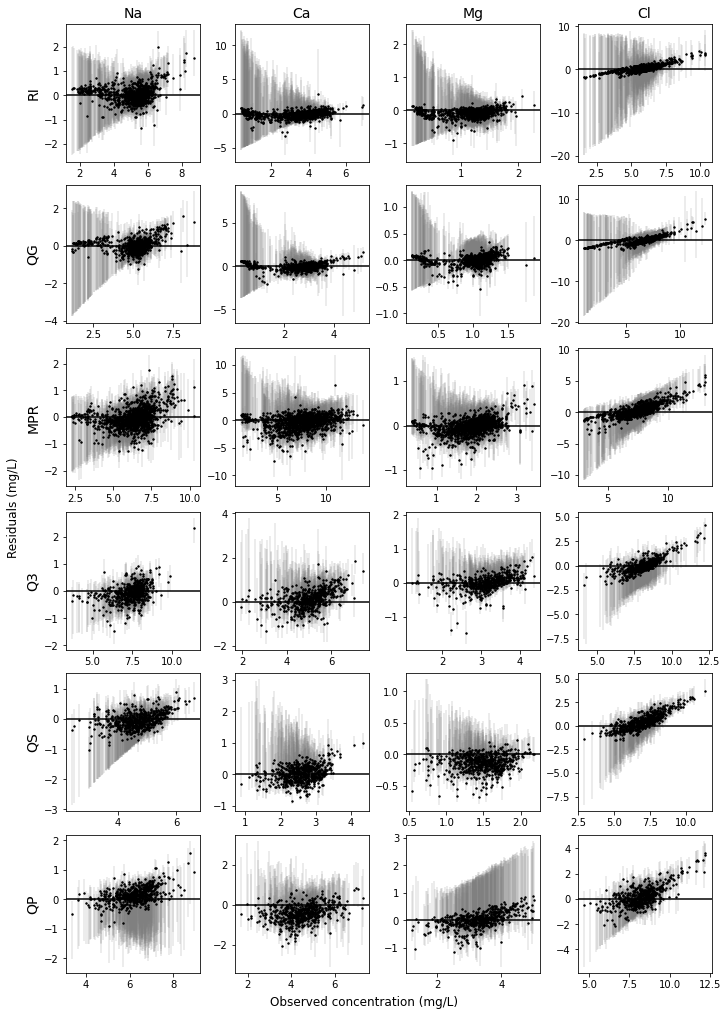

In [24]:
### this is for Supplemental plot 0, comparing back-calculated results with original measurements

# prep figure
fig,ax = plt.subplots(6,len(elementlist),constrained_layout=True,figsize=(10,14))

# prep outputdf
outdf2 = pd.DataFrame(index=sitelist)

for i,site in enumerate(sitelist):    
    period = '_h'
    tempdf = pd.read_csv(f'EMMAresults/{site}_{"-".join(elementlist)}.csv')

    for ei,e in enumerate(elementlist):
        # get residuals and the 5-95%
        residuals = tempdf[f'{e}']-tempdf[f'{e}_backcalc_med']
        residuals5 = tempdf[f'{e}']-tempdf[f'{e}_backcalc_5']
        residuals95 = tempdf[f'{e}']-tempdf[f'{e}_backcalc_95']
        
        ax[i,ei].scatter(tempdf[f'{e}'],residuals,s=2,c='k',zorder=2)
        ax[i,ei].errorbar(tempdf[f'{e}'],residuals,
                          yerr=[residuals-residuals95,residuals5-residuals],
                          ls='',marker='',alpha=0.2,color='gray',zorder=1)
     
        ## save plot limits
        lims = [np.min([ax[i,ei].get_xlim(), ax[i,ei].get_ylim()]),
                np.max([ax[i,ei].get_xlim(), ax[i,ei].get_ylim()])]
        
        xlims = [np.min(ax[i,ei].get_xlim()),
                np.max(ax[i,ei].get_xlim())]
            
        # make 1:1 line
        ax[i,ei].plot(xlims,[0,0],'k-',zorder=2)
        # return to original plot limits
        ax[i,ei].set_xlim(xlims)
            
        # slope + intercept of measured vs. modeled
        slope, intercept, r_value, p_value, std_err = stats.linregress(tempdf[f'{e}'],tempdf[f'{e}_backcalc_med'])
        # save
        outdf2.loc[site,f'{e}_slope'] = slope
        outdf2.loc[site,f'{e}_rsq'] = r_value**2
                
        if i==0:
            ax[0,ei].set_title(e,fontsize=14)
    
    ax[i,0].set_ylabel(site,fontsize=14)

# labels
fig.supxlabel('Observed concentration (mg/L)')
fig.supylabel('Residuals (mg/L)')

# save
plt.savefig('plots/FigS9_PCAresults.pdf')

# save supplemental table of PCA backcalculated metrics
outdf2.to_csv('tables/WRR_Supptable_PCA.csv')